In [1]:
from plantcv import plantcv as pcv

In [2]:
def clean_image(img):
    """
    To delete name and centercrop
    """
    H,W,_ = img.shape
    img = img[:W,...]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[W//4:W//4+W//2,W//4:W//4+W//2]
    return img

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cv2
from albumentations import Rotate
from scipy import ndimage
import imutils
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import medial_axis, skeletonize, thin, remove_small_objects
from rdp import rdp
import rdp

In [6]:
# img_path = sorted(glob.glob('centered_imgs/*/*'))
img_path = sorted(glob.glob('FAZ_Tortuosity/*/*')) #Original Folder

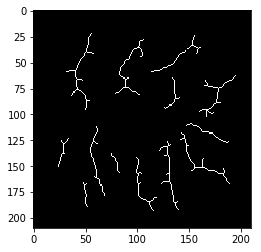

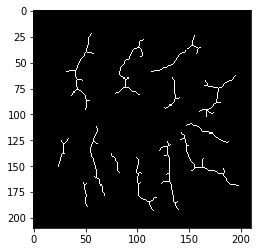

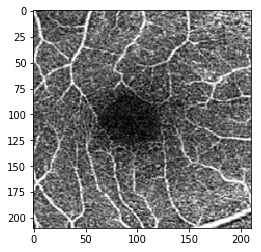

In [7]:
img_orig = clean_image(plt.imread(img_path[0])) 
kernel = np.ones((2,2),np.uint8) #kernel for erosion and dilation

# img_denoise = cv2.fastNlMeansDenoising(img_orig,None,39,7,21) #mean denoising

image = (hessian(img_orig,)*255).astype('uint8') #ridge detection

# image =  cv2.dilate(image,kernel,iterations = 1) #to join disconnected before removing small noise

image = remove_small_objects(image.astype(bool), min_size=64, connectivity=0).astype(float)

image = cv2.dilate(image,kernel,iterations = 3) #to join disconnected 
image = cv2.erode(image,kernel,iterations = 3)  #to join disconnected
image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected
image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected

#Use any one below
skel = skeletonize(image)
# skel = thin(image)
# med, distance = medial_axis(image, return_distance=True)
# # skel = med*distance

#To get the circular part
mask = np.zeros_like(image, np.uint8)
H,W = image.shape
mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
masked_data = cv2.bitwise_and(skel*255, skel*255, mask=mask)

plt.imshow(masked_data,cmap ='gray')
plt.show()
plt.imshow(skel,cmap ='gray')
plt.show()
plt.imshow(img_orig,cmap ='gray')
plt.show()

In [8]:
def get_points(skeleton_image):
    cnts = cv2.findContours(skeleton_image.copy().astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [9]:
def num_to_str(contour):
    str_list = list()
    for c in contour:
        str_list.append(str(c[0][0])+','+str(c[0][1]))
    return str_list

def get_unique(contour):
    cont = contour.copy()
    str_list = num_to_str(cont)
    index_dict = dict()
    for i in range(len(str_list)):
        if str_list[i] not in index_dict.keys():
            index_dict[str_list[i]] = i
    new_dict = dict((val,key) for key,val in index_dict.items())
    sub_cont = list()
    keys = list(new_dict.keys())
    keys.sort()
    sub_cont.append(list())
    last_ind = 0
    sub_cont[last_ind].append(new_dict[keys[0]])
    for i in range(len(keys)-1):
        if keys[i+1]-keys[i]!=1:
            last_ind+=1
            sub_cont.append(list())
            sub_cont[last_ind].append(new_dict[keys[i+1]])
        else:
            sub_cont[last_ind].append(new_dict[keys[i+1]])
    num_cont = sub_cont.copy()
    for l in range(len(num_cont)):
        for s in range(len(num_cont[l])):
            nums = num_cont[l][s].split(',')
            x = int(nums[0])
            y = int(nums[1])
            num_cont[l][s] = [x,y]
    return num_cont

In [10]:
def angle(dir):
    """
    Returns the angles between vectors.

    Parameters:
    dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.

    The return value is a 1D-array of values of shape (N-1,), with each value
    between 0 and pi.

    0 implies the vectors point in the same direction
    pi/2 implies the vectors are orthogonal
    pi implies the vectors point in opposite directions
    """
    dir2 = dir[1:]
    dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

In [11]:
def get_turning_points_contour(contour, tolerance, min_angle):
    points = np.array(contour)
    simplified = np.array(rdp.rdp(points.tolist(), tolerance))
    sx, sy = simplified.T
    # compute the direction vectors on the simplified curve
    directions = np.diff(simplified, axis=0)
    theta = angle(directions)
    # Select the index of the points with the greatest theta
    # Large theta is associated with greatest change in direction.
    idx = np.where(theta>min_angle)[0]+1
    return np.array([sx[idx], sy[idx]])

def get_turning_points(image, tolerance, min_angle):
    contours = get_points(image)
    corner_points = []
    for contour in contours:
        uniques = get_unique(contour)
        for unique in uniques:
            corner_point = get_turning_points_contour(unique, tolerance, min_angle)
            if corner_point.size != 0:
                corner_points.append(corner_point.T)
                
    points = []
    for pt in corner_points:
        for p in pt:
            points.append(p)
    points = np.array(points)
    return points

In [12]:
points = get_turning_points(masked_data, tolerance = 2, min_angle = np.pi*0.15)

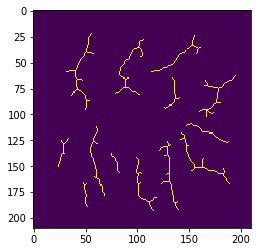

In [13]:
plt.imshow(masked_data)

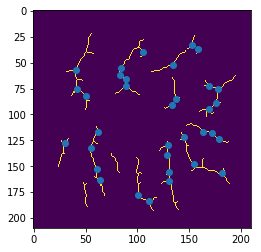

In [14]:
plt.scatter(points.T[0],points.T[1])
plt.imshow(masked_data,cmap='gray')
plt.imshow(masked_data)

In [15]:
masked_data.astype(np.uint8)
xshape,yshape = masked_data.shape
# masked_data.reshape((xshape,yshape,1))

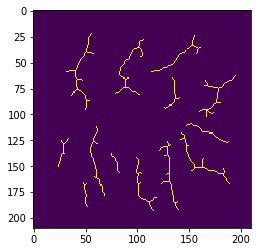

In [16]:
plt.imshow(masked_data)

In [17]:
masked_data = masked_data.astype(np.uint8)

In [18]:
branch_pts_img = pcv.morphology.find_branch_pts(masked_data)

In [19]:
z = np.zeros((210,210))
z = 0.3*masked_data + 0.7*branch_pts_img

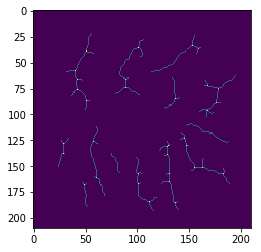

In [20]:
plt.imshow(z)

In [21]:
all_points = get_points(masked_data)

In [22]:
all_points

[array([[[ 48, 166]],
 
        [[ 48, 167]],
 
        [[ 49, 168]],
 
        [[ 49, 169]],
 
        [[ 49, 170]],
 
        [[ 49, 171]],
 
        [[ 49, 172]],
 
        [[ 50, 173]],
 
        [[ 50, 174]],
 
        [[ 50, 175]],
 
        [[ 50, 176]],
 
        [[ 51, 177]],
 
        [[ 51, 178]],
 
        [[ 51, 179]],
 
        [[ 50, 180]],
 
        [[ 50, 181]],
 
        [[ 50, 182]],
 
        [[ 50, 183]],
 
        [[ 50, 184]],
 
        [[ 50, 185]],
 
        [[ 50, 186]],
 
        [[ 51, 187]],
 
        [[ 51, 188]],
 
        [[ 52, 189]],
 
        [[ 51, 188]],
 
        [[ 51, 187]],
 
        [[ 50, 186]],
 
        [[ 50, 185]],
 
        [[ 50, 184]],
 
        [[ 50, 183]],
 
        [[ 50, 182]],
 
        [[ 50, 181]],
 
        [[ 50, 180]],
 
        [[ 51, 179]],
 
        [[ 51, 178]],
 
        [[ 51, 177]],
 
        [[ 50, 176]],
 
        [[ 50, 175]],
 
        [[ 50, 174]],
 
        [[ 50, 173]],
 
        [[ 49, 172]],
 
        [[ 49, 1

In [23]:
br_x,br_y = branch_pts_img.shape

In [24]:
branching_points = list()

In [25]:
for i in range(br_x):
    for j in range(br_y):
        if branch_pts_img[i][j] == 255:
            branching_points.append([[j,i]])

In [26]:
branching_points

[[[153, 34]],
 [[101, 36]],
 [[159, 37]],
 [[51, 39]],
 [[40, 58]],
 [[42, 66]],
 [[89, 66]],
 [[168, 72]],
 [[89, 74]],
 [[178, 75]],
 [[42, 76]],
 [[137, 85]],
 [[51, 87]],
 [[176, 89]],
 [[168, 96]],
 [[145, 123]],
 [[58, 126]],
 [[29, 128]],
 [[130, 130]],
 [[147, 130]],
 [[129, 131]],
 [[29, 138]],
 [[129, 139]],
 [[155, 151]],
 [[163, 151]],
 [[101, 157]],
 [[131, 157]],
 [[183, 157]],
 [[61, 161]],
 [[131, 165]],
 [[101, 167]],
 [[49, 168]],
 [[112, 184]],
 [[137, 185]]]

In [27]:
cont_wise_bp = list()
all_bp = list()
for bp in branching_points:
    print(bp)
    break

[[153, 34]]


In [28]:
def isSame(pix1,pix2):
    return (pix1[0][0] == pix2[0][0]) and (pix1[0][1] == pix2[0][1])

In [29]:
for cont in all_points:
    bp_cont = list()
    for pix in cont:
        for bp in branching_points:
#             print(pix,bp)
            if isSame(pix,bp):
#                 print('found')
                bp_cont.append(bp)
                all_bp.append(bp)
    cont_wise_bp.append(bp_cont)

In [30]:
all_bp

[[[49, 168]],
 [[49, 168]],
 [[101, 167]],
 [[112, 184]],
 [[101, 167]],
 [[101, 157]],
 [[101, 157]],
 [[130, 130]],
 [[129, 131]],
 [[129, 139]],
 [[129, 139]],
 [[131, 165]],
 [[137, 185]],
 [[131, 165]],
 [[131, 157]],
 [[129, 139]],
 [[129, 131]],
 [[130, 130]],
 [[29, 128]],
 [[29, 128]],
 [[29, 138]],
 [[145, 123]],
 [[147, 130]],
 [[155, 151]],
 [[163, 151]],
 [[183, 157]],
 [[183, 157]],
 [[145, 123]],
 [[58, 126]],
 [[61, 161]],
 [[61, 161]],
 [[58, 126]],
 [[137, 85]],
 [[137, 85]],
 [[178, 75]],
 [[168, 72]],
 [[168, 72]],
 [[178, 75]],
 [[176, 89]],
 [[168, 96]],
 [[168, 96]],
 [[176, 89]],
 [[178, 75]],
 [[89, 66]],
 [[89, 74]],
 [[89, 66]],
 [[101, 36]],
 [[153, 34]],
 [[159, 37]],
 [[159, 37]],
 [[159, 37]],
 [[51, 39]],
 [[40, 58]],
 [[42, 66]],
 [[42, 76]],
 [[51, 87]],
 [[42, 66]],
 [[42, 66]],
 [[40, 58]],
 [[51, 39]],
 [[51, 39]]]

In [31]:
def num_to_str(contour):
    str_list = list()
    for c in contour:
        str_list.append(str(c[0][0])+','+str(c[0][1]))
    return str_list

def get_unique(contour):
    cont = contour.copy()
    str_list = num_to_str(cont)
    index_dict = dict()
    for i in range(len(str_list)):
        if str_list[i] not in index_dict.keys():
            index_dict[str_list[i]] = i
    new_dict = dict((val,key) for key,val in index_dict.items())
    sub_cont = list()
    keys = list(new_dict.keys())
    keys.sort()
    sub_cont.append(list())
    last_ind = 0
    sub_cont[last_ind].append(new_dict[keys[0]])
    for i in range(len(keys)-1):
        if keys[i+1]-keys[i]!=1:
            last_ind+=1
            sub_cont.append(list())
            sub_cont[last_ind].append(new_dict[keys[i+1]])
        else:
            sub_cont[last_ind].append(new_dict[keys[i+1]])
    num_cont = sub_cont.copy()
    for l in range(len(num_cont)):
        for s in range(len(num_cont[l])):
            nums = num_cont[l][s].split(',')
            x = int(nums[0])
            y = int(nums[1])
            num_cont[l][s] = [x,y]
    return num_cont

In [32]:
for i in range(len(cont_wise_bp)):
    cont_wise_bp[i] = get_unique(cont_wise_bp[i])

IndexError: list index out of range

In [33]:
cont_wise_bp

[[[[49, 168]]],
 [[[101, 167], [112, 184]], [[101, 157]]],
 [],
 [[[130, 130]],
  [[129, 131]],
  [[129, 139]],
  [[129, 139]],
  [[131, 165]],
  [[137, 185]],
  [[131, 165]],
  [[131, 157]],
  [[129, 139]],
  [[129, 131]],
  [[130, 130]]],
 [[[29, 128]], [[29, 128]], [[29, 138]]],
 [[[145, 123]],
  [[147, 130]],
  [[155, 151]],
  [[163, 151]],
  [[183, 157]],
  [[183, 157]],
  [[145, 123]]],
 [[[58, 126]], [[61, 161]], [[61, 161]], [[58, 126]]],
 [],
 [[[137, 85]], [[137, 85]]],
 [[[178, 75]],
  [[168, 72]],
  [[168, 72]],
  [[178, 75]],
  [[176, 89]],
  [[168, 96]],
  [[168, 96]],
  [[176, 89]],
  [[178, 75]]],
 [],
 [[[89, 66]], [[89, 74]], [[89, 66]], [[101, 36]]],
 [[[153, 34]], [[159, 37]], [[159, 37]], [[159, 37]]],
 [[[51, 39]],
  [[40, 58]],
  [[42, 66]],
  [[42, 76]],
  [[51, 87]],
  [[42, 66]],
  [[42, 66]],
  [[40, 58]],
  [[51, 39]],
  [[51, 39]]]]

# Getting endpoints:

In [34]:
def has_one_n(pixel_m):
    num = 0
    if pixel_m[1][1]==255:
        for i in range(3):
            for j in range(3):
                if i==1 and j==1:
                    continue
                elif pixel_m[i][j]==255:
                    num+=1
        if num==1:
            return True
    else:
        return False
def ending_points(skeleton_image):
    shape = skeleton_image.shape
    branching_points = []
    for i in range(1,shape[0]-1):
        for j in  range(1,shape[1]-1):
            if has_one_n(np.copy(skeleton_image[i-1:i+2,j-1:j+2])):
                branching_points.append([[j,i]])
    return branching_points

In [35]:
ep = ending_points(masked_data)

In [36]:
def distance(pix1,pix2):
    dx = pix1[0][0]-pix2[0][0]
    dy = pix1[0][1]-pix2[0][1]
    return np.sqrt(dx**2+dy**2)

In [37]:
all_distances = list()
for i in range(len(all_bp)):
    for j in  range(len(ep)):
        if distance(all_bp[i],ep[j]) == 1.4142135623730951:
            print(all_bp[i],ep[j])
        all_distances.append(distance(all_bp[i],ep[j]))

In [38]:
all_distances = np.array(all_distances)

In [39]:
all_distances.sort()

In [40]:
all_distances

array([  2.        ,   2.23606798,   2.23606798, ..., 188.22327167,
       188.22327167, 188.22327167])

In [41]:
def calcAngle(origin,p1,p2):
    orx = origin[0]
    ory = origin[1]
    p1x = p1[0]
    p1y = p1[1]
    p2x = p2[0]
    p2y = p2[1]
    p1x-=orx
    p2x-=orx
    p1y-=ory
    p2y-=ory
    dot = p1x*p2x+p1y*p2y
    mod = np.sqrt(p1x**2+p1y**2)*np.sqrt(p2x**2+p2y**2)
    angle = np.arccos(dot/mod)
    angle/=np.pi
    angle*=180
    return angle

In [42]:
def detectPoints(image,origin,r=5):
    detected = list()
    d_theta = np.pi/180
    for i in range(361):
        if image[origin[1]+int(r*np.cos(d_theta*i)),origin[0]+int(r*np.sin(d_theta*i))] == 255:
#             print(10+int(r*np.cos(d_theta*i)),10+int(r*np.sin(d_theta*i)))
            detected.append([[origin[0]+int(r*np.sin(d_theta*i)),origin[1]+int(r*np.cos(d_theta*i))]])
    detected = get_unique(detected)
    points = list()
    for pts in detected:
        for x in pts:
            points.append([x])
    return points

In [43]:
vectors = list()
for bp in all_bp:
    vectors.append(tuple([bp[0],detectPoints(masked_data,bp[0])]))

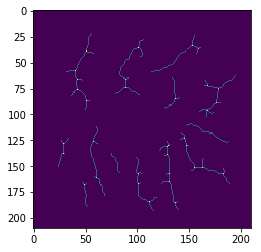

In [44]:
plt.imshow(z)

In [45]:
vectors

[([49, 168], [[[49, 172]]]),
 ([49, 168], [[[49, 172]]]),
 ([101, 167], [[[101, 172]], [[101, 171]], [[100, 163]]]),
 ([112, 184], [[[113, 188]], [[116, 182]], [[108, 182]]]),
 ([101, 167], [[[101, 172]], [[101, 171]], [[100, 163]]]),
 ([101, 157], [[[99, 153]], [[100, 161]]]),
 ([101, 157], [[[99, 153]], [[100, 161]]]),
 ([130, 130], [[[129, 126]], [[126, 131]], [[129, 134]]]),
 ([129, 131],
  [[[129, 136]], [[129, 135]], [[129, 127]], [[129, 126]], [[125, 131]]]),
 ([129, 139], [[[131, 143]], [[129, 135]], [[129, 134]]]),
 ([129, 139], [[[131, 143]], [[129, 135]], [[129, 134]]]),
 ([131, 165],
  [[[133, 169]], [[131, 161]], [[131, 160]], [[127, 165]], [[126, 165]]]),
 ([137, 185], [[[138, 189]], [[135, 181]]]),
 ([131, 165],
  [[[133, 169]], [[131, 161]], [[131, 160]], [[127, 165]], [[126, 165]]]),
 ([131, 157], [[[131, 162]], [[131, 161]], [[131, 153]], [[131, 152]]]),
 ([129, 139], [[[131, 143]], [[129, 135]], [[129, 134]]]),
 ([129, 131],
  [[[129, 136]], [[129, 135]], [[129, 127]

In [46]:
# angles with reference to vertical:
angles = list()
for v in vectors:
    origin = v[0]
    points = v[1]
    angle = list()
    for pts in points:
        hyp = [origin[0],origin[1]+1]
#         print(origin,pts[0])
#         print(calcAngle(origin,pts[0],hyp))
        angle.append(calcAngle(origin,pts[0],hyp))
    angles.append(angle)

In [47]:
angles

[[0.0],
 [0.0],
 [0.0, 0.0, 165.96375653207352],
 [14.036243467926484, 116.56505117707799, 116.56505117707799],
 [0.0, 0.0, 165.96375653207352],
 [153.43494882292202, 14.036243467926484],
 [153.43494882292202, 14.036243467926484],
 [165.96375653207352, 75.96375653207353, 14.036243467926484],
 [0.0, 0.0, 180.0, 180.0, 90.0],
 [26.565051177077994, 180.0, 180.0],
 [26.565051177077994, 180.0, 180.0],
 [26.565051177077994, 180.0, 180.0, 90.0, 90.0],
 [14.036243467926484, 153.43494882292202],
 [26.565051177077994, 180.0, 180.0, 90.0, 90.0],
 [0.0, 0.0, 180.0, 180.0],
 [26.565051177077994, 180.0, 180.0],
 [0.0, 0.0, 180.0, 180.0, 90.0],
 [165.96375653207352, 75.96375653207353, 14.036243467926484],
 [0.0, 0.0],
 [0.0, 0.0],
 [180.0, 180.0],
 [14.036243467926484, 165.96375653207352],
 [0.0, 0.0, 165.96375653207352],
 [90.0, 90.0, 165.96375653207352, 45.0],
 [75.96375653207353, 180.0, 180.0, 90.0, 90.0],
 [26.565051177077994, 180.0, 180.0, 90.0, 90.0],
 [26.565051177077994, 180.0, 180.0, 90.0, 9